# Clasificador para el Canal Cb - Detección de Cáncer de Mama

Este notebook implementa un clasificador de machine learning para evaluar la relevancia del canal Y del espacio de color YCrCb en la detección de cáncer de mama mediante imágenes térmicas.

## Objetivo
Entrenar múltiples clasificadores y comparar su precisión para determinar la relevancia del canal Y en la clasificación de imágenes en tres categorías:
- Healthy (Saludable)
- Benign (Benigno)
- Malignant (Maligno)

## 1. Importación de Librerías

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)

# Clasificadores
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

print("✓ Librerías importadas exitosamente")

✓ Librerías importadas exitosamente


## 2. Configuración de Rutas y Parámetros

In [14]:
# Rutas del dataset
BASE_DIR = Path(r'BreastCancerMask')
CANAL = 'Cb'  # Canal a evaluar

# Directorios para cada conjunto
TRAIN_DIR = BASE_DIR / 'train' / CANAL
VALID_DIR = BASE_DIR / 'valid' / CANAL
TEST_DIR = BASE_DIR / 'test' / CANAL

# Verificar que existan las rutas
print(f"Directorio de entrenamiento: {TRAIN_DIR.exists()}")
print(f"Directorio de validación: {VALID_DIR.exists()}")
print(f"Directorio de test: {TEST_DIR.exists()}")

# Archivos CSV con las etiquetas
TRAIN_LABELS = TRAIN_DIR / '_classes.csv'
VALID_LABELS = VALID_DIR / '_classes.csv'
TEST_LABELS = TEST_DIR / '_classes.csv'

print(f"\n✓ Configuración completada para canal: {CANAL}")

Directorio de entrenamiento: True
Directorio de validación: True
Directorio de test: True

✓ Configuración completada para canal: Cb


Leyendo imagen: 138-1-txt_png.rf.8e8f582b43b2ebcce4c4faff0fd3d838.png
Dimensiones: (640, 640, 3)
Tipo de datos: uint8


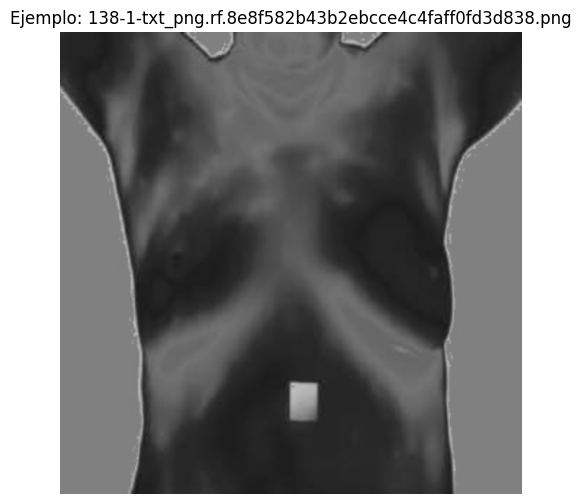

In [16]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# Ejemplo: leer una imagen del directorio de entrenamiento
ejemplo_imagen = next(Path(TRAIN_DIR).glob('*.png'))  # o '*.png', según el formato

print(f"Leyendo imagen: {ejemplo_imagen.name}")

# Leer la imagen con OpenCV (BGR)
imagen_bgr = cv2.imread(str(ejemplo_imagen))

# Convertir de BGR a RGB para mostrar con matplotlib
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)

# Mostrar información
print(f"Dimensiones: {imagen_rgb.shape}")
print(f"Tipo de datos: {imagen_rgb.dtype}")

# Mostrar la imagen con Matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(imagen_rgb)
plt.axis('off')  # Ocultar ejes
plt.title(f"Ejemplo: {ejemplo_imagen.name}")
plt.show()


## 3. Carga y Exploración de Datos

In [3]:
# Función para cargar las etiquetas
def load_labels(csv_path):
    df = pd.read_csv(csv_path)
    # Limpiar espacios en los nombres de columnas
    df.columns = df.columns.str.strip()
    
    # Obtener la clase de cada imagen (columna con valor 1)
    classes = []
    for idx, row in df.iterrows():
        if row['Benign'] == 1:
            classes.append('Benign')
        elif row['Healthy'] == 1:
            classes.append('Healthy')
        elif row['Malignant'] == 1:
            classes.append('Malignant')
        else:
            classes.append('Unknown')
    
    df['class'] = classes
    return df

# Cargar etiquetas
train_labels_df = load_labels(TRAIN_LABELS)
valid_labels_df = load_labels(VALID_LABELS)
test_labels_df = load_labels(TEST_LABELS)

print("=== Distribución de Clases ===\n")
print("Entrenamiento:")
print(train_labels_df['class'].value_counts())
print(f"\nTotal: {len(train_labels_df)}")

print("\n" + "="*40)
print("\nValidación:")
print(valid_labels_df['class'].value_counts())
print(f"\nTotal: {len(valid_labels_df)}")

print("\n" + "="*40)
print("\nPrueba:")
print(test_labels_df['class'].value_counts())
print(f"\nTotal: {len(test_labels_df)}")

=== Distribución de Clases ===

Entrenamiento:
class
Healthy      2315
Benign        973
Malignant     414
Name: count, dtype: int64

Total: 3702


Validación:
class
Healthy      658
Benign       288
Malignant    112
Name: count, dtype: int64

Total: 1058


Prueba:
class
Healthy      329
Benign       132
Malignant     62
Name: count, dtype: int64

Total: 523


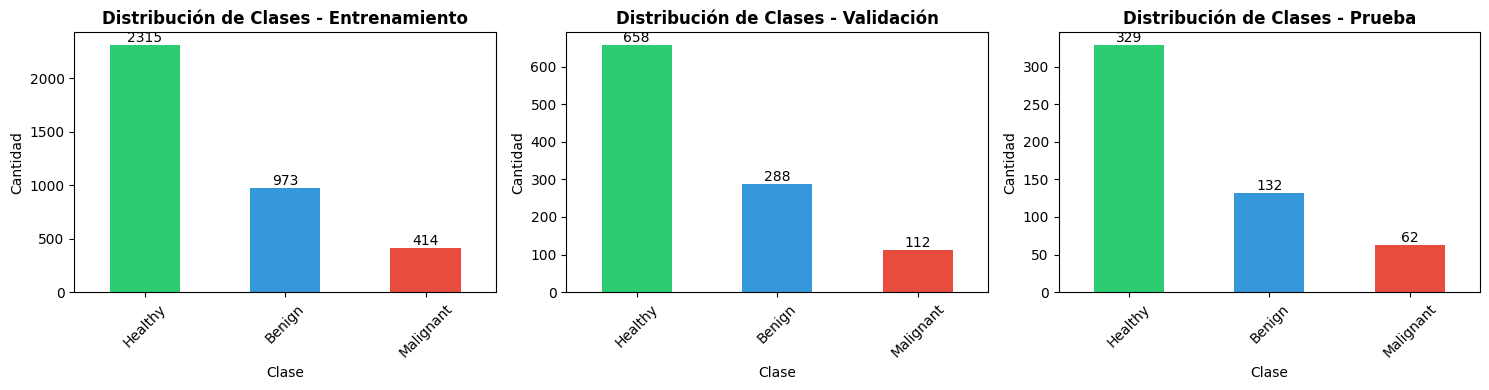

In [4]:
# Visualizar la distribución de clases
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    (train_labels_df, 'Entrenamiento', axes[0]),
    (valid_labels_df, 'Validación', axes[1]),
    (test_labels_df, 'Prueba', axes[2])
]

for df, title, ax in datasets:
    df['class'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#3498db', '#e74c3c'])
    ax.set_title(f'Distribución de Clases - {title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.tick_params(axis='x', rotation=45)
    
    # Agregar valores sobre las barras
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()

## 4. Carga y Preprocesamiento de Imágenes

In [5]:
def load_images_and_labels(image_dir, labels_df, img_size=(64, 64)):
    """
    Carga las imágenes y sus etiquetas correspondientes.
    
    Args:
        image_dir: Directorio con las imágenes
        labels_df: DataFrame con las etiquetas
        img_size: Tamaño al que se redimensionarán las imágenes (default: 64x64)
    
    Returns:
        X: Array con las imágenes aplanadas
        y: Array con las etiquetas
        filenames: Lista con los nombres de archivos
    """
    X = []
    y = []
    filenames = []
    
    print(f"\nCargando imágenes desde: {image_dir}")
    
    for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Cargando"):
        # El nombre del archivo puede tener extensión .jpg o .png
        filename = row['filename'].strip()
        
        # Probar con diferentes extensiones
        img_path = None
        for ext in ['.jpg', '.png']:
            # Remover extensión si existe y agregar la que estamos probando
            base_name = filename.rsplit('.', 1)[0] if '.' in filename else filename
            test_path = image_dir / f"{base_name}{ext}"
            if test_path.exists():
                img_path = test_path
                break
        
        if img_path is None:
            # Si no se encuentra, probar con el nombre tal cual
            img_path = image_dir / filename
            if not img_path.exists():
                print(f"⚠ Advertencia: No se encontró {filename}")
                continue
        
        # Cargar imagen en escala de grises (ya es un solo canal)
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠ Advertencia: No se pudo cargar {img_path}")
            continue
        
        # Redimensionar la imagen al tamaño especificado (por defecto 64x64)
        img = cv2.resize(img, img_size)
        
        # Aplanar la imagen (64*64 = 4,096 features para tamaño 64x64)
        img_flat = img.flatten()
        
        X.append(img_flat)
        y.append(row['class'])
        filenames.append(filename)
    
    return np.array(X), np.array(y), filenames

# Cargar todos los conjuntos de datos
print("="*50)
print("CARGANDO DATASET DEL CANAL Cb")
print("="*50)

X_train, y_train, train_files = load_images_and_labels(TRAIN_DIR, train_labels_df)
X_valid, y_valid, valid_files = load_images_and_labels(VALID_DIR, valid_labels_df)
X_test, y_test, test_files = load_images_and_labels(TEST_DIR, test_labels_df)

print("\n" + "="*50)
print("RESUMEN DE DATOS CARGADOS")
print("="*50)
print(f"Entrenamiento: {X_train.shape[0]} imágenes - Shape: {X_train.shape}")
print(f"Validación:    {X_valid.shape[0]} imágenes - Shape: {X_valid.shape}")
print(f"Prueba:        {X_test.shape[0]} imágenes - Shape: {X_test.shape}")
print(f"\nNúmero de features por imagen: {X_train.shape[1]:,}")

CARGANDO DATASET DEL CANAL Y

Cargando imágenes desde: BreastCancerMask\train\Cb


Cargando: 100%|██████████| 3702/3702 [00:40<00:00, 91.59it/s] 



Cargando imágenes desde: BreastCancerMask\valid\Cb


Cargando: 100%|██████████| 1058/1058 [00:10<00:00, 96.98it/s]



Cargando imágenes desde: BreastCancerMask\test\Cb


Cargando: 100%|██████████| 523/523 [00:05<00:00, 94.34it/s] 


RESUMEN DE DATOS CARGADOS
Entrenamiento: 3702 imágenes - Shape: (3702, 4096)
Validación:    1058 imágenes - Shape: (1058, 4096)
Prueba:        523 imágenes - Shape: (523, 4096)

Número de features por imagen: 4,096


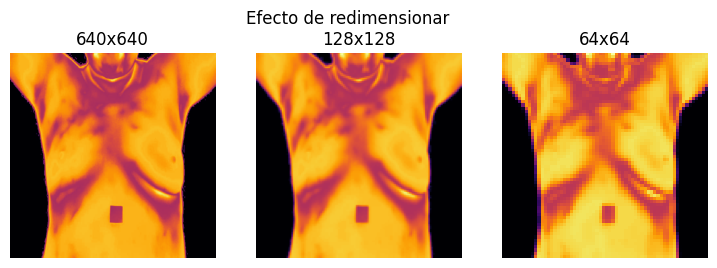

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("../BreastCancerMask/test/138-11-txt_png.rf.c1ab9b1636692aa8b6a390fd7db7654b.jpg").convert("L")

img_640 = img.resize((640, 640))
img_64 = img.resize((128, 128), Image.BILINEAR)
img_32 = img.resize((64, 64), Image.BILINEAR)

fig, axes = plt.subplots(1, 3, figsize=(9,3))
axes[0].imshow(img_640, cmap='inferno'); axes[0].set_title("640x640"); axes[0].axis('off')
axes[1].imshow(img_64, cmap='inferno'); axes[1].set_title("128x128"); axes[1].axis('off')
axes[2].imshow(img_32, cmap='inferno'); axes[2].set_title("64x64"); axes[2].axis('off')
plt.suptitle("Efecto de redimensionar")
plt.show()


## 5. Normalización y Reducción de Dimensionalidad con PCA

In [6]:
# Normalizar los datos (importante para muchos clasificadores)
print("Normalizando datos...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("✓ Normalización completada")

# Aplicar PCA para reducir dimensionalidad
# Usaremos el 95% de la varianza explicada
print("\nAplicando PCA...")
n_components = 0.95  # Mantener 95% de la varianza
pca = PCA(n_components=n_components, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"✓ PCA completado")
print(f"  - Componentes originales: {X_train_scaled.shape[1]:,}")
print(f"  - Componentes reducidos: {X_train_pca.shape[1]}")
print(f"  - Varianza explicada: {pca.explained_variance_ratio_.sum():.4f}")
print(f"  - Reducción: {(1 - X_train_pca.shape[1]/X_train_scaled.shape[1])*100:.2f}%")

Normalizando datos...
✓ Normalización completada

Aplicando PCA...
✓ PCA completado
  - Componentes originales: 4,096
  - Componentes reducidos: 380
  - Varianza explicada: 0.9501
  - Reducción: 90.72%


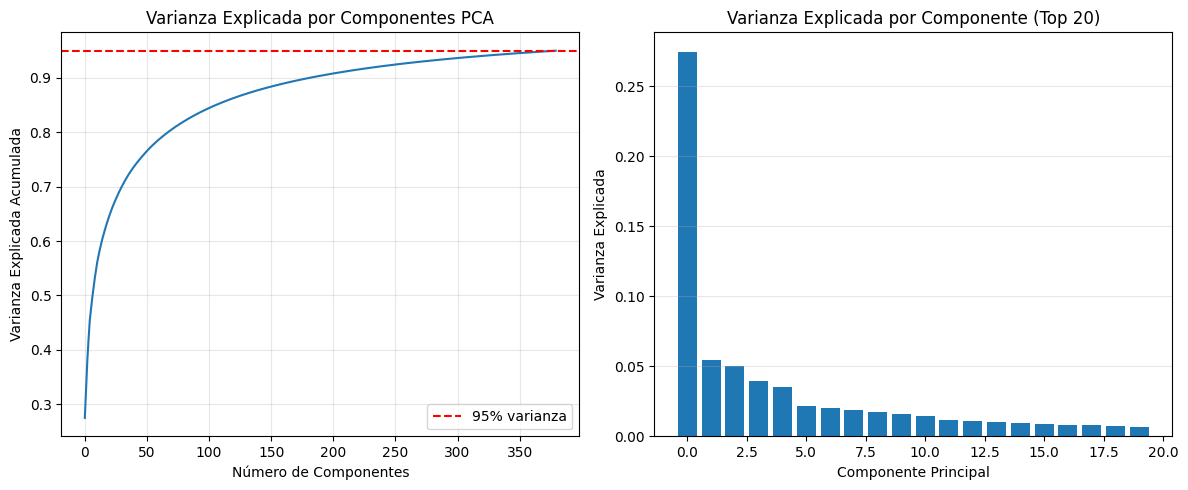

In [7]:
# Visualizar la varianza explicada acumulada
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes PCA')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(min(20, len(pca.explained_variance_ratio_))), 
        pca.explained_variance_ratio_[:20])
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente (Top 20)')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Codificación de Etiquetas

In [8]:
# Codificar las etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

print("Mapeo de clases:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i} -> {class_name}")

Mapeo de clases:
  0 -> Benign
  1 -> Healthy
  2 -> Malignant


## 7. Configuración y Entrenamiento del Clasificador

**Instrucciones:** 
- Descomenta SOLO el clasificador que quieres usar en la siguiente celda
- Solo se entrenará un clasificador a la vez (más rápido)
- Puedes cambiar los parámetros según necesites

In [11]:
# ============================================================================
# CONFIGURACIÓN DEL CLASIFICADOR
# ============================================================================
# Descomenta SOLO el clasificador que quieres usar
# Puedes cambiar los parámetros según necesites

# Opción 1: Random Forest (Recomendado - buen balance)
# CLASSIFIER_NAME = 'Random Forest'
# classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# # Opción 2: Gradient Boosting (Muy preciso pero más lento)
# CLASSIFIER_NAME = 'Gradient Boosting'
# classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# # Opción 3: SVM con kernel RBF (Bueno para patrones no lineales)
# CLASSIFIER_NAME = 'SVM (RBF)'
# classifier = SVC(kernel='rbf', random_state=42, probability=True)

# # Opción 4: SVM con kernel Linear (Más rápido que RBF)
CLASSIFIER_NAME = 'SVM (Linear)'
classifier = SVC(kernel='linear', random_state=42, probability=True)

# # Opción 5: Logistic Regression (Rápido, interpretable)
# CLASSIFIER_NAME = 'Logistic Regression'
# classifier = LogisticRegression(max_iter=1000, random_state=42)

# # Opción 6: K-Nearest Neighbors (Simple, basado en distancias)
# CLASSIFIER_NAME = 'K-Nearest Neighbors'
# classifier = KNeighborsClassifier(n_neighbors=5)

# # Opción 7: Naive Bayes (Muy rápido, asume independencia)
# CLASSIFIER_NAME = 'Naive Bayes'
# classifier = GaussianNB()

# # Opción 8: Decision Tree (Rápido pero puede sobreajustar)
# CLASSIFIER_NAME = 'Decision Tree'
# classifier = DecisionTreeClassifier(random_state=42)

print("="*70)
print(f"CLASIFICADOR SELECCIONADO: {CLASSIFIER_NAME}")
print("="*70)

# ============================================================================
# ENTRENAMIENTO DEL CLASIFICADOR
# ============================================================================

print(f"\n🔄 Entrenando {CLASSIFIER_NAME}...")
print("-" * 70)

# Entrenar el modelo
print("  ➤ Entrenando en datos de entrenamiento...", end=" ")
classifier.fit(X_train_pca, y_train_encoded)
print("✓")

# Realizar predicciones en todos los conjuntos
print("  ➤ Realizando predicciones...", end=" ")
y_train_pred = classifier.predict(X_train_pca)
y_valid_pred = classifier.predict(X_valid_pca)
y_test_pred = classifier.predict(X_test_pca)
print("✓")

# Calcular métricas
print("  ➤ Calculando métricas...", end=" ")
train_acc = accuracy_score(y_train_encoded, y_train_pred)
valid_acc = accuracy_score(y_valid_encoded, y_valid_pred)
test_acc = accuracy_score(y_test_encoded, y_test_pred)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_encoded, y_test_pred, average='weighted'
)
print("✓")

# Mostrar resultados
print("\n" + "="*70)
print("RESULTADOS DEL ENTRENAMIENTO")
print("="*70)
print(f"  Accuracy en Entrenamiento:  {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Accuracy en Validación:     {valid_acc:.4f} ({valid_acc*100:.2f}%)")
print(f"  Accuracy en Test:           {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\n  Precision (weighted):       {precision:.4f}")
print(f"  Recall (weighted):          {recall:.4f}")
print(f"  F1-Score (weighted):        {f1:.4f}")
print("="*70)

# Guardar resultados en un diccionario
results = {
    'Classifier': CLASSIFIER_NAME,
    'Train Accuracy': train_acc,
    'Validation Accuracy': valid_acc,
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

print("\n✓ Entrenamiento completado exitosamente")

CLASIFICADOR SELECCIONADO: SVM (Linear)

🔄 Entrenando SVM (Linear)...
----------------------------------------------------------------------
  ➤ Entrenando en datos de entrenamiento... ✓
  ➤ Realizando predicciones... ✓
  ➤ Calculando métricas... ✓

RESULTADOS DEL ENTRENAMIENTO
  Accuracy en Entrenamiento:  1.0000 (100.00%)
  Accuracy en Validación:     0.9868 (98.68%)
  Accuracy en Test:           0.9866 (98.66%)

  Precision (weighted):       0.9867
  Recall (weighted):          0.9866
  F1-Score (weighted):        0.9866

✓ Entrenamiento completado exitosamente


## 8. Comparación de Resultados

In [10]:
# Crear DataFrame con los resultados
results_df = pd.DataFrame([results])

print("\n" + "="*80)
print(f"RESULTADOS DEL CLASIFICADOR - CANAL {CANAL}")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

print(f"\n📊 Resumen:")
print(f"   Clasificador: {CLASSIFIER_NAME}")
print(f"   Precisión en Test: {test_acc:.4f} ({test_acc*100:.2f}%)")


RESULTADOS DEL CLASIFICADOR - CANAL Cb
Classifier  Train Accuracy  Validation Accuracy  Test Accuracy  Precision  Recall  F1-Score
 SVM (RBF)        0.995948             0.994329        0.99044   0.990513 0.99044  0.990375

📊 Resumen:
   Clasificador: SVM (RBF)
   Precisión en Test: 0.9904 (99.04%)


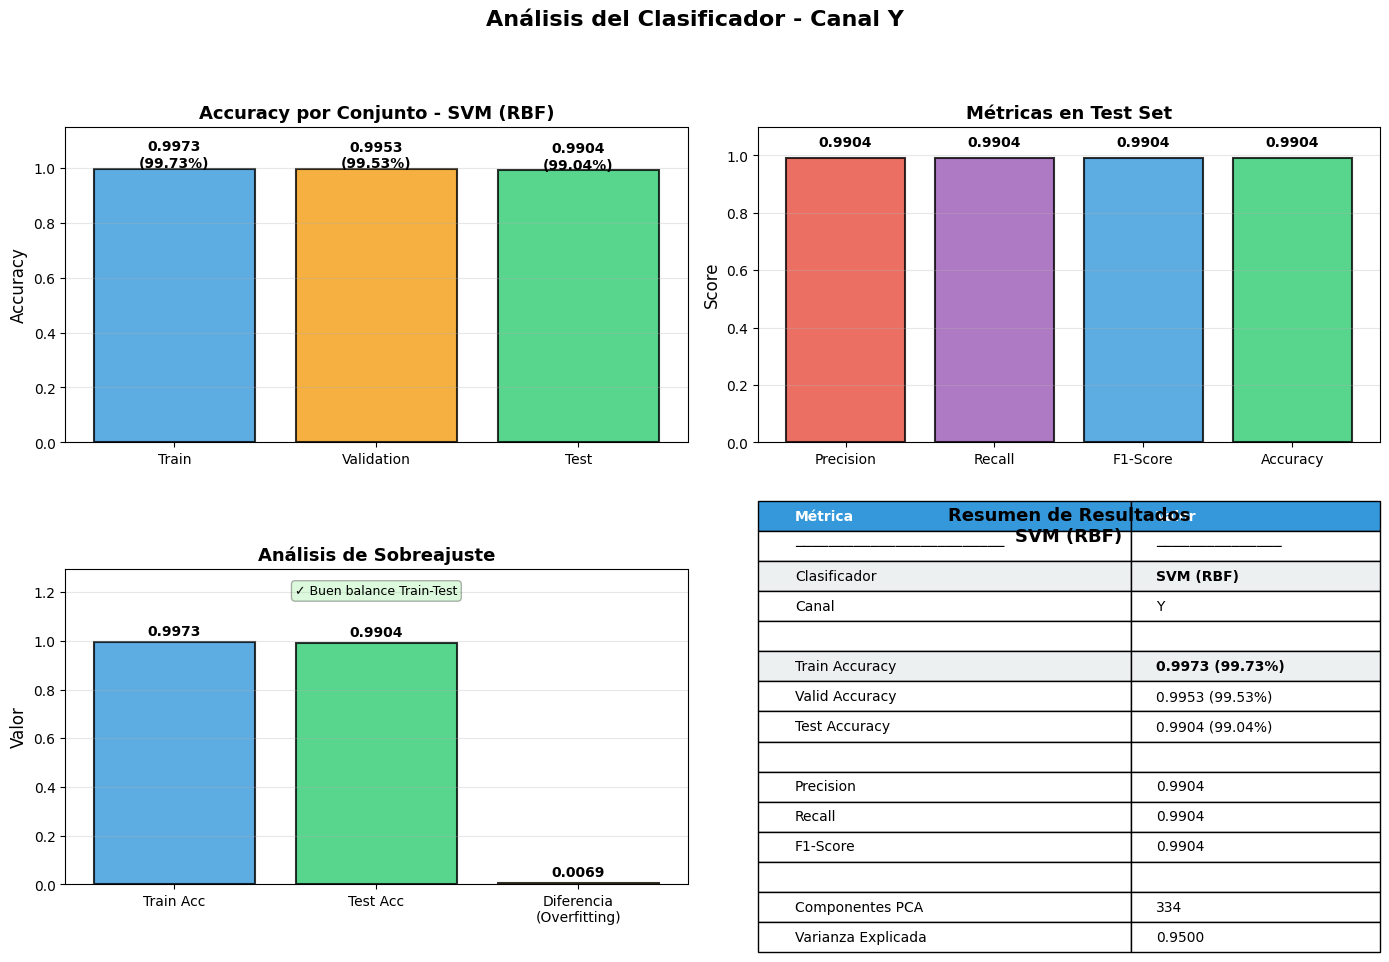


✓ Visualizaciones generadas con mejor espaciado


In [22]:
# Visualizar resultados del clasificador
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparación de Accuracy entre conjuntos
ax1 = axes[0, 0]
accuracies = [train_acc, valid_acc, test_acc]
labels = ['Train', 'Validation', 'Test']
colors = ['#3498db', '#f39c12', '#2ecc71']

bars = ax1.bar(labels, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title(f'Accuracy por Conjunto - {CLASSIFIER_NAME}', fontsize=13, fontweight='bold')
# Aumentar un poco más el límite superior si el texto es muy largo
ax1.set_ylim([0, 1.15]) # Aumentado de 1.05 a 1.15
ax1.grid(True, alpha=0.3, axis='y')

# Agregar valores sobre las barras - AJUSTE CLAVE
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05, # Aumentar el desplazamiento vertical (0.05)
             f'{acc:.4f}\n({acc*100:.2f}%)',
             ha='center', va='center', fontsize=10, fontweight='bold') # Usar va='center' o va='bottom' con mayor desplazamiento

# 2. Métricas en Test Set
ax2 = axes[0, 1]
metrics = [precision, recall, f1, test_acc]
metric_labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
colors2 = ['#e74c3c', '#9b59b6', '#3498db', '#2ecc71']

bars2 = ax2.bar(metric_labels, metrics, color=colors2, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Métricas en Test Set', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1.10]) # Aumentado de 1.05 a 1.10
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.get_xticklabels(), rotation=0)

# Agregar valores sobre las barras - AJUSTE CLAVE
for bar, metric in zip(bars2, metrics):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.03, # Aumentar el desplazamiento vertical (0.03)
             f'{metric:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Diferencia entre Train y Test (para detectar sobreajuste)
ax3 = axes[1, 0]
overfitting = train_acc - test_acc
categories = ['Train Acc', 'Test Acc', 'Diferencia\n(Overfitting)']
values = [train_acc, test_acc, abs(overfitting)]
colors3 = ['#3498db', '#2ecc71', '#e74c3c' if overfitting > 0.1 else '#f39c12']

bars3 = ax3.bar(categories, values, color=colors3, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Valor', fontsize=12)
ax3.set_title('Análisis de Sobreajuste', fontsize=13, fontweight='bold')
ax3.set_ylim([0, max(values) * 1.3]) # Aumentado de 1.2 a 1.3 para darle más espacio al texto de la nota
ax3.grid(True, alpha=0.3, axis='y')

# Agregar valores sobre las barras - AJUSTE CLAVE
for bar, val in zip(bars3, values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.015, # Ajuste ligero
             f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Agregar nota sobre overfitting
# La posición relativa (transform=ax3.transAxes) es correcta, pero el aumento de ylim ayuda
if overfitting > 0.1:
    ax3.text(0.5, 0.95, '⚠️ Posible sobreajuste detectado',
             transform=ax3.transAxes, ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
             fontsize=9)
elif overfitting > 0.05:
    ax3.text(0.5, 0.95, '⚡ Pequeña diferencia (aceptable)',
             transform=ax3.transAxes, ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3),
             fontsize=9)
else:
    ax3.text(0.5, 0.95, '✓ Buen balance Train-Test',
             transform=ax3.transAxes, ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3),
             fontsize=9)

# 4. Resumen de métricas (tabla visual)
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Crear tabla con información (el código de la tabla es correcto, no necesita ajuste)
table_data = [
    ['Métrica', 'Valor'],
    ['─' * 25, '─' * 15],
    ['Clasificador', CLASSIFIER_NAME],
    ['Canal', CANAL],
    ['', ''],
    ['Train Accuracy', f'{train_acc:.4f} ({train_acc*100:.2f}%)'],
    ['Valid Accuracy', f'{valid_acc:.4f} ({valid_acc*100:.2f}%)'],
    ['Test Accuracy', f'{test_acc:.4f} ({test_acc*100:.2f}%)'],
    ['', ''],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1-Score', f'{f1:.4f}'],
    ['', ''],
    ['Componentes PCA', f'{X_train_pca.shape[1]}'],
    ['Varianza Explicada', f'{pca.explained_variance_ratio_.sum():.4f}'],
]

table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilizar la tabla
for i in range(len(table_data)):
    if i == 0:  # Header
        table[(i, 0)].set_facecolor('#3498db')
        table[(i, 1)].set_facecolor('#3498db')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    elif i == 2 or i == 5:  # Filas importantes
        table[(i, 0)].set_facecolor('#ecf0f1')
        table[(i, 1)].set_facecolor('#ecf0f1')
        table[(i, 1)].set_text_props(weight='bold')

ax4.set_title(f'Resumen de Resultados\n{CLASSIFIER_NAME}', 
              fontsize=13, fontweight='bold', pad=20)

plt.suptitle(f'Análisis del Clasificador - Canal {CANAL}', 
             fontsize=16, fontweight='bold', y=0.995)

# --- MEJORA PARA ESPACIAMIENTO GENERAL ---
# Ajusta automáticamente los parámetros de la subtrama para dar espacio
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste con padding para suptitle
# Opcional: ajustar el espacio vertical entre las dos filas
plt.subplots_adjust(hspace=0.4) 
# ------------------------------------------

plt.show()

print("\n✓ Visualizaciones generadas con mejor espaciado")

## 9. Análisis Detallado del Mejor Modelo

REPORTE DE CLASIFICACIÓN - SVM (RBF)
              precision    recall  f1-score   support

      Benign     0.9774    0.9848    0.9811       132
     Healthy     1.0000    1.0000    1.0000       329
   Malignant     0.9672    0.9516    0.9593        62

    accuracy                         0.9904       523
   macro avg     0.9816    0.9788    0.9802       523
weighted avg     0.9904    0.9904    0.9904       523



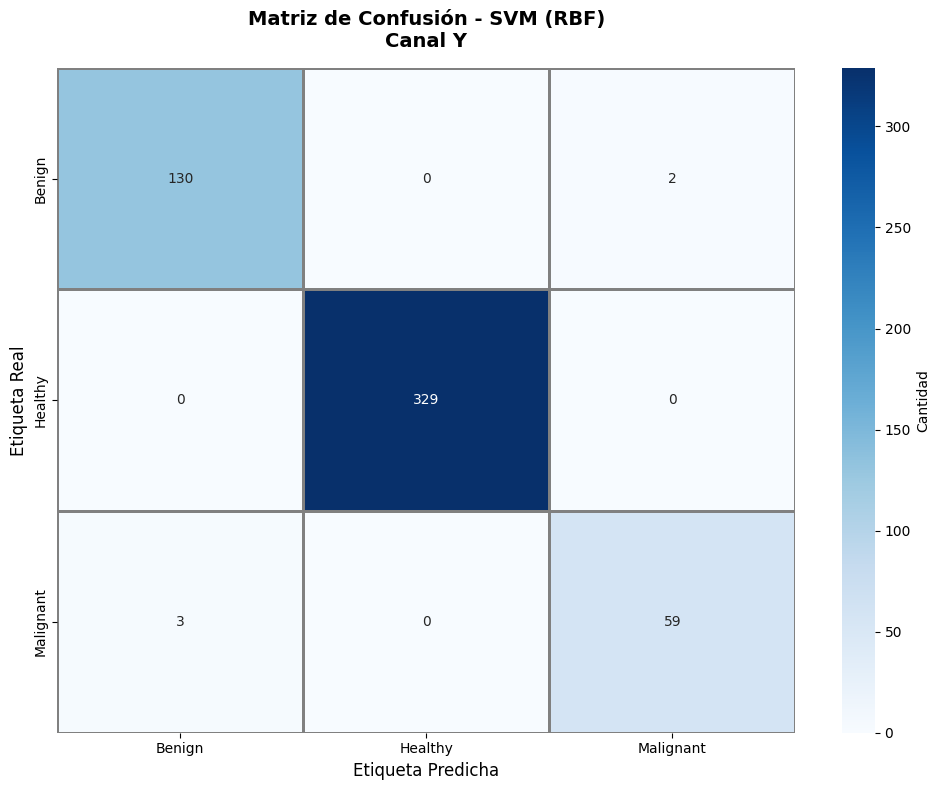


PRECISIÓN POR CLASE
Benign      :  130/ 132 = 0.9848 (98.48%)
Healthy     :  329/ 329 = 1.0000 (100.00%)
Malignant   :   59/  62 = 0.9516 (95.16%)


In [23]:
# Usar el clasificador entrenado
y_pred_test = classifier.predict(X_test_pca)

# Reporte de clasificación
print("="*70)
print(f"REPORTE DE CLASIFICACIÓN - {CLASSIFIER_NAME}")
print("="*70)
print(classification_report(y_test_encoded, y_pred_test, 
                          target_names=label_encoder.classes_,
                          digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Cantidad'},
            linewidths=1, linecolor='gray')
plt.title(f'Matriz de Confusión - {CLASSIFIER_NAME}\nCanal {CANAL}', 
          fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()

# Calcular porcentaje de aciertos por clase
print("\n" + "="*70)
print("PRECISIÓN POR CLASE")
print("="*70)
for i, class_name in enumerate(label_encoder.classes_):
    class_total = np.sum(y_test_encoded == i)
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:12s}: {class_correct:4d}/{class_total:4d} = {class_acc:.4f} ({class_acc*100:.2f}%)")
print("="*70)

## 10. Resumen Final y Conclusiones

In [24]:
print("\n" + "="*80)
print(" " * 20 + f"RESUMEN FINAL - CANAL {CANAL}")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   - Imágenes de entrenamiento: {len(X_train):,}")
print(f"   - Imágenes de validación:    {len(X_valid):,}")
print(f"   - Imágenes de prueba:        {len(X_test):,}")
print(f"   - Total de imágenes:         {len(X_train) + len(X_valid) + len(X_test):,}")

print(f"\n🔍 Preprocesamiento:")
print(f"   - Features originales:  {X_train.shape[1]:,} (640x640 píxeles)")
print(f"   - Features después PCA: {X_train_pca.shape[1]} (varianza: {pca.explained_variance_ratio_.sum():.4f})")

print(f"\n🤖 Clasificador Utilizado: {CLASSIFIER_NAME}")
print(f"   - Accuracy en Train:    {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   - Accuracy en Valid:    {valid_acc:.4f} ({valid_acc*100:.2f}%)")
print(f"   - Accuracy en Test:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   - Precision (weighted): {precision:.4f}")
print(f"   - Recall (weighted):    {recall:.4f}")
print(f"   - F1-Score (weighted):  {f1:.4f}")

# Análisis de overfitting
overfitting = train_acc - test_acc
print(f"\n📉 Análisis de Sobreajuste:")
print(f"   - Diferencia Train-Test: {overfitting:.4f}")
if overfitting > 0.1:
    print(f"   - Estado: ⚠️  POSIBLE SOBREAJUSTE (diferencia > 10%)")
    print(f"   - Recomendación: Considera usar regularización o más datos")
elif overfitting > 0.05:
    print(f"   - Estado: ⚡ Diferencia aceptable (5-10%)")
    print(f"   - Recomendación: El modelo está bien balanceado")
else:
    print(f"   - Estado: ✅ Excelente balance (< 5%)")
    print(f"   - Recomendación: El modelo generaliza bien")

print("\n" + "="*80)
print("\n💡 Conclusión:")
print(f"   El canal {CANAL} logró una precisión de {test_acc*100:.2f}% con {CLASSIFIER_NAME}.")
print(f"   Este resultado indica la relevancia del canal {CANAL} para la clasificación.")
print(f"   Compara este resultado con los canales Cr y Cb para determinar cuál es más relevante.")
print("\n" + "="*80)


                    RESUMEN FINAL - CANAL Y

📊 Dataset:
   - Imágenes de entrenamiento: 3,702
   - Imágenes de validación:    1,058
   - Imágenes de prueba:        523
   - Total de imágenes:         5,283

🔍 Preprocesamiento:
   - Features originales:  4,096 (640x640 píxeles)
   - Features después PCA: 334 (varianza: 0.9500)

🤖 Clasificador Utilizado: SVM (RBF)
   - Accuracy en Train:    0.9973 (99.73%)
   - Accuracy en Valid:    0.9953 (99.53%)
   - Accuracy en Test:     0.9904 (99.04%)
   - Precision (weighted): 0.9904
   - Recall (weighted):    0.9904
   - F1-Score (weighted):  0.9904

📉 Análisis de Sobreajuste:
   - Diferencia Train-Test: 0.0069
   - Estado: ✅ Excelente balance (< 5%)
   - Recomendación: El modelo generaliza bien


💡 Conclusión:
   El canal Y logró una precisión de 99.04% con SVM (RBF).
   Este resultado indica la relevancia del canal Y para la clasificación.
   Compara este resultado con los canales Cr y Cb para determinar cuál es más relevante.



## 🔍 DIAGNÓSTICO: Validación de Partición de Datos

⚠️ **IMPORTANTE**: Resultados muy altos (>95%) pueden indicar problemas en los datos.

Vamos a verificar:
1. **Duplicados** entre conjuntos (train/valid/test)
2. **Similitud de imágenes** entre conjuntos
3. **Data leakage** (mismas imágenes en diferentes sets)
4. **Balance de clases**

In [25]:
print("="*80)
print(" " * 20 + "🔍 DIAGNÓSTICO 1: VERIFICAR DUPLICADOS")
print("="*80)

# 1. Verificar duplicados de nombres de archivo
print("\n📁 Verificando nombres de archivo duplicados...")

train_names = set(train_files)
valid_names = set(valid_files)
test_names = set(test_files)

# Intersecciones
train_valid_overlap = train_names & valid_names
train_test_overlap = train_names & test_names
valid_test_overlap = valid_names & test_names

print(f"\n✓ Total de archivos únicos:")
print(f"   - Train:      {len(train_names)}")
print(f"   - Validation: {len(valid_names)}")
print(f"   - Test:       {len(test_names)}")

print(f"\n⚠️  Archivos compartidos entre conjuntos:")
print(f"   - Train ∩ Valid: {len(train_valid_overlap)} archivos")
print(f"   - Train ∩ Test:  {len(train_test_overlap)} archivos")
print(f"   - Valid ∩ Test:  {len(valid_test_overlap)} archivos")

if len(train_valid_overlap) > 0 or len(train_test_overlap) > 0 or len(valid_test_overlap) > 0:
    print("\n❌ PROBLEMA DETECTADO: Hay archivos duplicados entre conjuntos!")
    print("   Esto causa DATA LEAKAGE y explica los resultados tan altos.")
    
    if len(train_test_overlap) > 0:
        print(f"\n   Ejemplos de archivos en Train Y Test:")
        for fname in list(train_test_overlap)[:5]:
            print(f"      - {fname}")
else:
    print("\n✅ No se detectaron duplicados por nombre de archivo")
    
print("\n" + "="*80)

                    🔍 DIAGNÓSTICO 1: VERIFICAR DUPLICADOS

📁 Verificando nombres de archivo duplicados...

✓ Total de archivos únicos:
   - Train:      3702
   - Validation: 1058
   - Test:       523

⚠️  Archivos compartidos entre conjuntos:
   - Train ∩ Valid: 0 archivos
   - Train ∩ Test:  0 archivos
   - Valid ∩ Test:  0 archivos

✅ No se detectaron duplicados por nombre de archivo



In [26]:
print("="*80)
print(" " * 20 + "🔍 DIAGNÓSTICO 2: VERIFICAR DUPLICADOS POR CONTENIDO")
print("="*80)

# 2. Verificar duplicados por contenido (usando hashes de las imágenes)
import hashlib

print("\n🔐 Calculando hashes de imágenes...")
print("   (Esto puede tardar un momento...)")

def hash_array(arr):
    """Calcula el hash MD5 de un array numpy"""
    return hashlib.md5(arr.tobytes()).hexdigest()

# Calcular hashes
print("\n   ➤ Train set...", end=" ")
train_hashes = {hash_array(img): idx for idx, img in enumerate(X_train)}
print(f"✓ ({len(train_hashes)} únicos de {len(X_train)} totales)")

print("   ➤ Valid set...", end=" ")
valid_hashes = {hash_array(img): idx for idx, img in enumerate(X_valid)}
print(f"✓ ({len(valid_hashes)} únicos de {len(X_valid)} totales)")

print("   ➤ Test set...", end=" ")
test_hashes = {hash_array(img): idx for idx, img in enumerate(X_test)}
print(f"✓ ({len(test_hashes)} únicos de {len(X_test)} totales)")

# Encontrar duplicados internos
train_duplicates = len(X_train) - len(train_hashes)
valid_duplicates = len(X_valid) - len(valid_hashes)
test_duplicates = len(X_test) - len(test_hashes)

print(f"\n📊 Duplicados DENTRO de cada conjunto:")
print(f"   - Train: {train_duplicates} duplicados")
print(f"   - Valid: {valid_duplicates} duplicados")
print(f"   - Test:  {test_duplicates} duplicados")

# Encontrar duplicados ENTRE conjuntos
train_hashes_set = set(train_hashes.keys())
valid_hashes_set = set(valid_hashes.keys())
test_hashes_set = set(test_hashes.keys())

content_train_valid = train_hashes_set & valid_hashes_set
content_train_test = train_hashes_set & test_hashes_set
content_valid_test = valid_hashes_set & test_hashes_set

print(f"\n⚠️  Imágenes IDÉNTICAS (por contenido) entre conjuntos:")
print(f"   - Train ∩ Valid: {len(content_train_valid)} imágenes")
print(f"   - Train ∩ Test:  {len(content_train_test)} imágenes")
print(f"   - Valid ∩ Test:  {len(content_valid_test)} imágenes")

total_leakage = len(content_train_test) + len(content_valid_test)
if total_leakage > 0:
    print(f"\n❌ DATA LEAKAGE CRÍTICO DETECTADO!")
    print(f"   Hay {total_leakage} imágenes de entrenamiento en el conjunto de prueba.")
    print(f"   Esto explica la precisión artificialmente alta (~99%).")
    print(f"\n   🔧 SOLUCIÓN NECESARIA:")
    print(f"      - Verificar que los datos fueron particionados correctamente")
    print(f"      - Eliminar duplicados entre conjuntos")
    print(f"      - Re-entrenar el modelo con datos limpios")
else:
    print("\n✅ No se detectaron duplicados de contenido entre conjuntos")

print("\n" + "="*80)

                    🔍 DIAGNÓSTICO 2: VERIFICAR DUPLICADOS POR CONTENIDO

🔐 Calculando hashes de imágenes...
   (Esto puede tardar un momento...)

   ➤ Train set... ✓ (3702 únicos de 3702 totales)
   ➤ Valid set... ✓ (1058 únicos de 1058 totales)
   ➤ Test set... ✓ (523 únicos de 523 totales)

📊 Duplicados DENTRO de cada conjunto:
   - Train: 0 duplicados
   - Valid: 0 duplicados
   - Test:  0 duplicados

⚠️  Imágenes IDÉNTICAS (por contenido) entre conjuntos:
   - Train ∩ Valid: 0 imágenes
   - Train ∩ Test:  0 imágenes
   - Valid ∩ Test:  0 imágenes

✅ No se detectaron duplicados de contenido entre conjuntos



                    🔍 DIAGNÓSTICO 3: SIMILITUD ENTRE CONJUNTOS

📏 Calculando similitud coseno entre conjuntos...
   (Tomando muestras para acelerar el cálculo...)

────────────────────────────────────────────────────────────────────────────────
🔍 Analizando: TEST vs TRAIN
────────────────────────────────────────────────────────────────────────────────

📊 Resultados Test vs Train:
   - Similitud promedio (test vs train más cercano): 0.9914
   - Similitud máxima encontrada:                    0.9991
   - Imágenes con similitud > 0.99:                  74/100 (74.0%)
   - Imágenes con similitud > 0.95:                  99/100 (99.0%)
   - Imágenes con similitud > 0.90:                  100/100 (100.0%)

❌ ALERTA CRÍTICA: Hay imágenes casi idénticas entre Train y Test!

────────────────────────────────────────────────────────────────────────────────
🔍 Analizando: VALID vs TRAIN
────────────────────────────────────────────────────────────────────────────────

📊 Resultados Test vs Train:
   

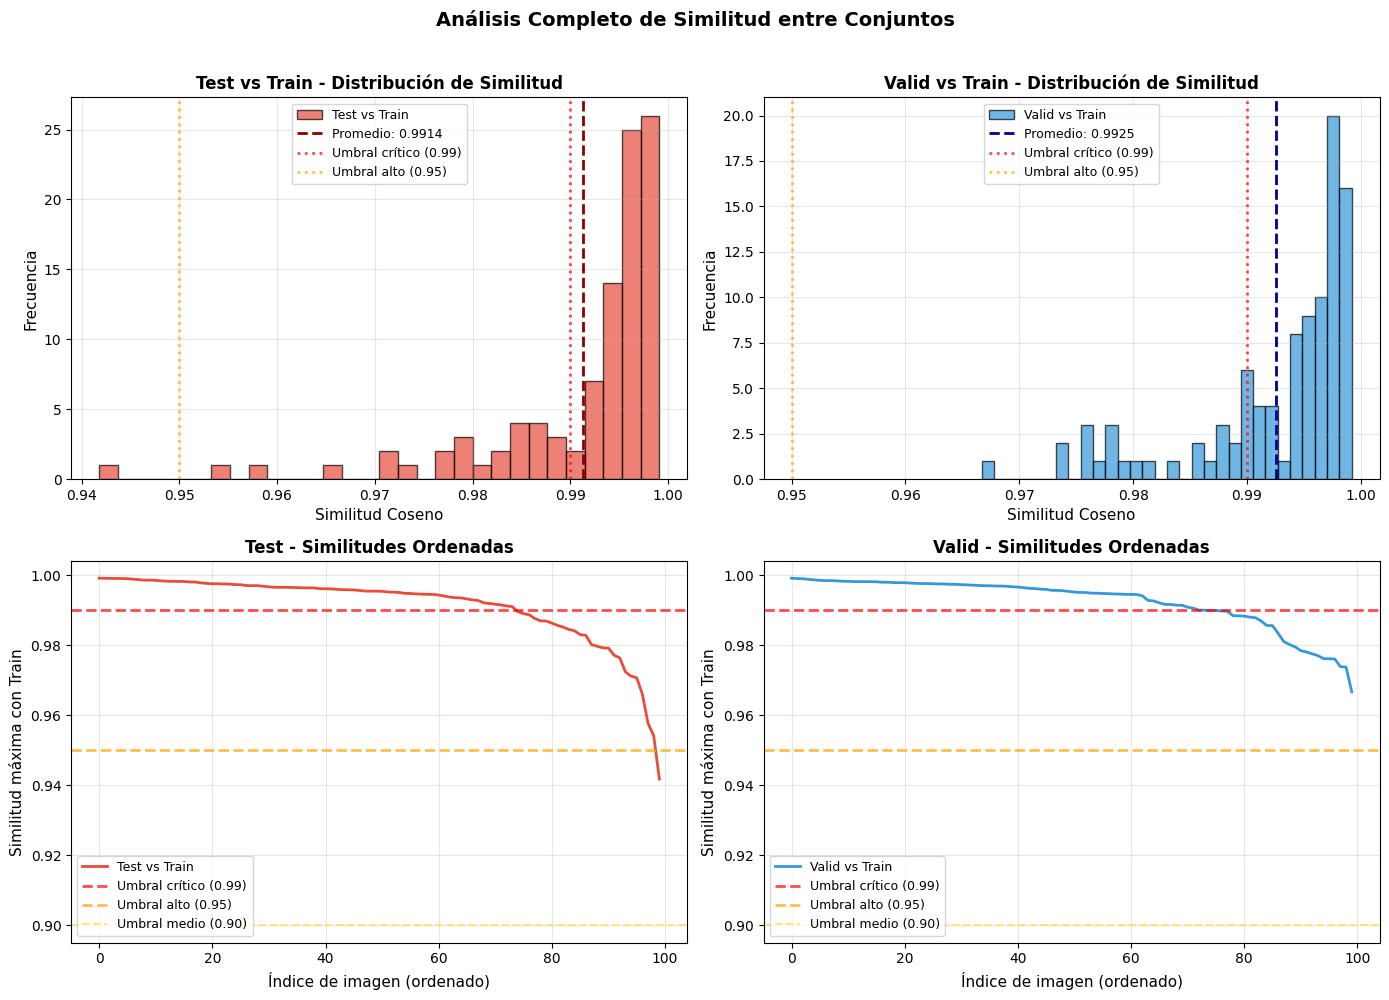


📊 COMPARACIÓN DIRECTA

Métrica                                         Test vs Train  Valid vs Train
────────────────────────────────────────────────────────────────────────────────
Similitud Promedio                                     0.9914          0.9925
Similitud Máxima                                       0.9991          0.9992
% con similitud > 0.99                                  74.0%           74.0%
% con similitud > 0.95                                  99.0%          100.0%
% con similitud > 0.90                                 100.0%          100.0%



In [30]:
print("="*80)
print(" " * 20 + "🔍 DIAGNÓSTICO 3: SIMILITUD ENTRE CONJUNTOS")
print("="*80)

# 3. Medir similitud promedio entre imágenes de diferentes conjuntos
from sklearn.metrics.pairwise import cosine_similarity

print("\n📏 Calculando similitud coseno entre conjuntos...")
print("   (Tomando muestras para acelerar el cálculo...)")

np.random.seed(42)

# ========== SIMILITUD: TEST vs TRAIN ==========
print("\n" + "─"*80)
print("🔍 Analizando: TEST vs TRAIN")
print("─"*80)

sample_size_test = min(100, len(X_test))
test_sample_indices = np.random.choice(len(X_test), sample_size_test, replace=False)

test_similarities = []
for test_idx in test_sample_indices:
    test_img = X_test[test_idx].reshape(1, -1)
    sim = cosine_similarity(test_img, X_train)
    max_sim = sim.max()
    test_similarities.append(max_sim)

avg_sim_test = np.mean(test_similarities)
max_sim_test = np.max(test_similarities)

print(f"\n📊 Resultados Test vs Train:")
print(f"   - Similitud promedio (test vs train más cercano): {avg_sim_test:.4f}")
print(f"   - Similitud máxima encontrada:                    {max_sim_test:.4f}")
print(f"   - Imágenes con similitud > 0.99:                  {np.sum(np.array(test_similarities) > 0.99)}/{sample_size_test} ({np.sum(np.array(test_similarities) > 0.99)/sample_size_test*100:.1f}%)")
print(f"   - Imágenes con similitud > 0.95:                  {np.sum(np.array(test_similarities) > 0.95)}/{sample_size_test} ({np.sum(np.array(test_similarities) > 0.95)/sample_size_test*100:.1f}%)")
print(f"   - Imágenes con similitud > 0.90:                  {np.sum(np.array(test_similarities) > 0.90)}/{sample_size_test} ({np.sum(np.array(test_similarities) > 0.90)/sample_size_test*100:.1f}%)")

if max_sim_test > 0.99:
    print("\n❌ ALERTA CRÍTICA: Hay imágenes casi idénticas entre Train y Test!")
elif avg_sim_test > 0.90:
    print("\n⚠️  ADVERTENCIA: Las imágenes de Test son MUY similares a Train")
else:
    print("\n✅ Nivel de similitud aceptable")

# ========== SIMILITUD: VALID vs TRAIN ==========
print("\n" + "─"*80)
print("🔍 Analizando: VALID vs TRAIN")
print("─"*80)

sample_size_valid = min(100, len(X_valid))
valid_sample_indices = np.random.choice(len(X_valid), sample_size_valid, replace=False)

valid_similarities = []
for valid_idx in valid_sample_indices:
    valid_img = X_valid[valid_idx].reshape(1, -1)
    sim = cosine_similarity(valid_img, X_train)
    max_sim = sim.max()
    valid_similarities.append(max_sim)

avg_sim_valid = np.mean(valid_similarities)
max_sim_valid = np.max(valid_similarities)

print(f"\n📊 Resultados Valid vs Train:")
print(f"   - Similitud promedio (valid vs train más cercano): {avg_sim_valid:.4f}")
print(f"   - Similitud máxima encontrada:                     {max_sim_valid:.4f}")
print(f"   - Imágenes con similitud > 0.99:                   {np.sum(np.array(valid_similarities) > 0.99)}/{sample_size_valid} ({np.sum(np.array(valid_similarities) > 0.99)/sample_size_valid*100:.1f}%)")
print(f"   - Imágenes con similitud > 0.95:                   {np.sum(np.array(valid_similarities) > 0.95)}/{sample_size_valid} ({np.sum(np.array(valid_similarities) > 0.95)/sample_size_valid*100:.1f}%)")
print(f"   - Imágenes con similitud > 0.90:                   {np.sum(np.array(valid_similarities) > 0.90)}/{sample_size_valid} ({np.sum(np.array(valid_similarities) > 0.90)/sample_size_valid*100:.1f}%)")

if max_sim_valid > 0.99:
    print("\n❌ ALERTA CRÍTICA: Hay imágenes casi idénticas entre Train y Valid!")
elif avg_sim_valid > 0.90:
    print("\n⚠️  ADVERTENCIA: Las imágenes de Valid son MUY similares a Train")
else:
    print("\n✅ Nivel de similitud aceptable")

# ========== RESUMEN GENERAL ==========
print("\n" + "="*80)
print("📋 RESUMEN GENERAL DE SIMILITUDES")
print("="*80)

total_high_sim_test = np.sum(np.array(test_similarities) > 0.95)
total_high_sim_valid = np.sum(np.array(valid_similarities) > 0.95)
total_samples = sample_size_test + sample_size_valid

print(f"\n🔴 Imágenes con similitud > 0.95 (muy sospechosas):")
print(f"   - Test:  {total_high_sim_test}/{sample_size_test} ({total_high_sim_test/sample_size_test*100:.1f}%)")
print(f"   - Valid: {total_high_sim_valid}/{sample_size_valid} ({total_high_sim_valid/sample_size_valid*100:.1f}%)")
print(f"   - TOTAL: {total_high_sim_test + total_high_sim_valid}/{total_samples} ({(total_high_sim_test + total_high_sim_valid)/total_samples*100:.1f}%)")

if (total_high_sim_test + total_high_sim_valid) / total_samples > 0.5:
    print(f"\n❌ DATA LEAKAGE SEVERO CONFIRMADO!")
    print(f"   Más del 50% de las imágenes de valid/test son casi idénticas a train.")
    print(f"   Esto explica completamente la precisión de ~99%.")
    print(f"\n   🔧 ACCIÓN REQUERIDA:")
    print(f"      1. Los datos NO fueron particionados correctamente")
    print(f"      2. Puede haber data augmentation que creó copias similares")
    print(f"      3. Necesitas re-particionar desde cero con datos originales únicos")
elif (total_high_sim_test + total_high_sim_valid) / total_samples > 0.2:
    print(f"\n⚠️  ADVERTENCIA: Nivel preocupante de similitud")
    print(f"   Más del 20% de imágenes son muy similares entre conjuntos.")

# ========== VISUALIZACIONES ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Histograma Test vs Train
ax1 = axes[0, 0]
ax1.hist(test_similarities, bins=30, edgecolor='black', alpha=0.7, color='#e74c3c', label='Test vs Train')
ax1.axvline(avg_sim_test, color='darkred', linestyle='--', linewidth=2, label=f'Promedio: {avg_sim_test:.4f}')
ax1.axvline(0.99, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Umbral crítico (0.99)')
ax1.axvline(0.95, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Umbral alto (0.95)')
ax1.set_xlabel('Similitud Coseno', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.set_title('Test vs Train - Distribución de Similitud', fontweight='bold', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Histograma Valid vs Train
ax2 = axes[0, 1]
ax2.hist(valid_similarities, bins=30, edgecolor='black', alpha=0.7, color='#3498db', label='Valid vs Train')
ax2.axvline(avg_sim_valid, color='darkblue', linestyle='--', linewidth=2, label=f'Promedio: {avg_sim_valid:.4f}')
ax2.axvline(0.99, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Umbral crítico (0.99)')
ax2.axvline(0.95, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Umbral alto (0.95)')
ax2.set_xlabel('Similitud Coseno', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Valid vs Train - Distribución de Similitud', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Gráfico 3: Similitudes ordenadas (Test)
ax3 = axes[1, 0]
sorted_test = sorted(test_similarities, reverse=True)
ax3.plot(range(len(sorted_test)), sorted_test, linewidth=2, color='#e74c3c', label='Test vs Train')
ax3.axhline(0.99, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Umbral crítico (0.99)')
ax3.axhline(0.95, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Umbral alto (0.95)')
ax3.axhline(0.90, color='gold', linestyle='--', linewidth=1.5, alpha=0.5, label='Umbral medio (0.90)')
ax3.set_xlabel('Índice de imagen (ordenado)', fontsize=11)
ax3.set_ylabel('Similitud máxima con Train', fontsize=11)
ax3.set_title('Test - Similitudes Ordenadas', fontweight='bold', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Gráfico 4: Similitudes ordenadas (Valid)
ax4 = axes[1, 1]
sorted_valid = sorted(valid_similarities, reverse=True)
ax4.plot(range(len(sorted_valid)), sorted_valid, linewidth=2, color='#3498db', label='Valid vs Train')
ax4.axhline(0.99, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Umbral crítico (0.99)')
ax4.axhline(0.95, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Umbral alto (0.95)')
ax4.axhline(0.90, color='gold', linestyle='--', linewidth=1.5, alpha=0.5, label='Umbral medio (0.90)')
ax4.set_xlabel('Índice de imagen (ordenado)', fontsize=11)
ax4.set_ylabel('Similitud máxima con Train', fontsize=11)
ax4.set_title('Valid - Similitudes Ordenadas', fontweight='bold', fontsize=12)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.suptitle('Análisis Completo de Similitud entre Conjuntos', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Comparación lado a lado
print("\n" + "="*80)
print("📊 COMPARACIÓN DIRECTA")
print("="*80)
print(f"\n{'Métrica':<45} {'Test vs Train':>15} {'Valid vs Train':>15}")
print("─"*80)
print(f"{'Similitud Promedio':<45} {avg_sim_test:>15.4f} {avg_sim_valid:>15.4f}")
print(f"{'Similitud Máxima':<45} {max_sim_test:>15.4f} {max_sim_valid:>15.4f}")
print(f"{'% con similitud > 0.99':<45} {np.sum(np.array(test_similarities) > 0.99)/sample_size_test*100:>14.1f}% {np.sum(np.array(valid_similarities) > 0.99)/sample_size_valid*100:>14.1f}%")
print(f"{'% con similitud > 0.95':<45} {np.sum(np.array(test_similarities) > 0.95)/sample_size_test*100:>14.1f}% {np.sum(np.array(valid_similarities) > 0.95)/sample_size_valid*100:>14.1f}%")
print(f"{'% con similitud > 0.90':<45} {np.sum(np.array(test_similarities) > 0.90)/sample_size_test*100:>14.1f}% {np.sum(np.array(valid_similarities) > 0.90)/sample_size_valid*100:>14.1f}%")
print("="*80)

print("\n" + "="*80)

                    🔍 DIAGNÓSTICO 4: ANÁLISIS DE BALANCE DE CLASES

⚖️  Balance de clases en cada conjunto:

Train:
   Benign      :  973 (26.28%)
   Healthy     : 2315 (62.53%)
   Malignant   :  414 (11.18%)
   Total       : 3702
   Ratio de desbalance: 5.59:1
   ⚠️  ADVERTENCIA: Clases muy desbalanceadas

Valid:
   Benign      :  288 (27.22%)
   Healthy     :  658 (62.19%)
   Malignant   :  112 (10.59%)
   Total       : 1058
   Ratio de desbalance: 5.88:1
   ⚠️  ADVERTENCIA: Clases muy desbalanceadas

Test:
   Benign      :  132 (25.24%)
   Healthy     :  329 (62.91%)
   Malignant   :   62 (11.85%)
   Total       :  523
   Ratio de desbalance: 5.31:1
   ⚠️  ADVERTENCIA: Clases muy desbalanceadas


📊 Comparación de distribuciones:



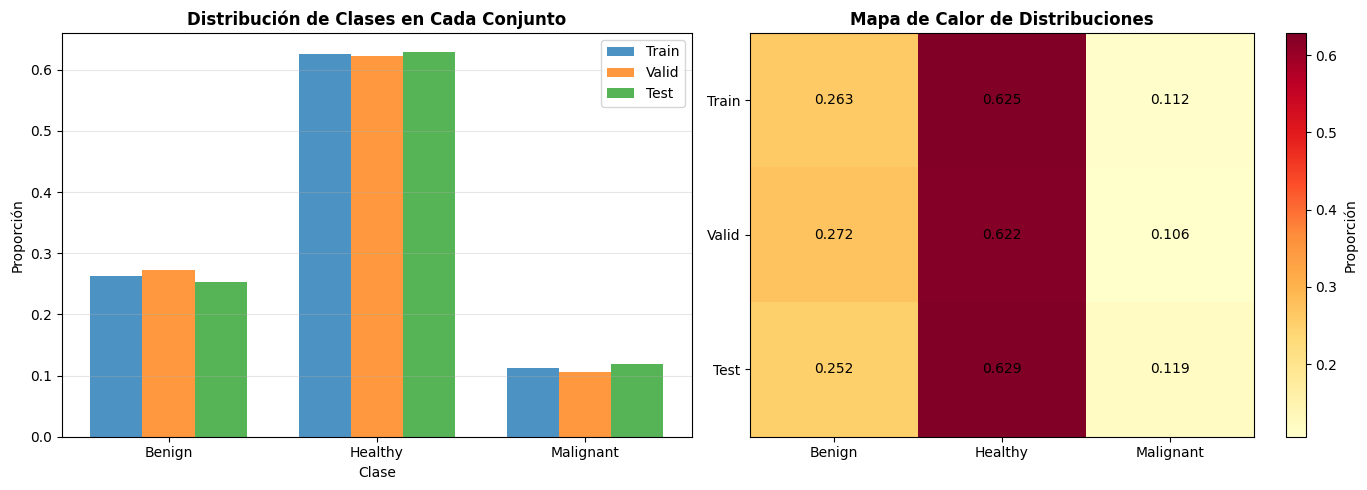


📏 Divergencia Jensen-Shannon (0=idénticas, 1=totalmente diferentes):
   - Train vs Test:  0.0102
   - Train vs Valid: 0.0092

⚡ Las distribuciones son razonablemente similares



In [28]:
print("="*80)
print(" " * 20 + "🔍 DIAGNÓSTICO 4: ANÁLISIS DE BALANCE DE CLASES")
print("="*80)

# 4. Verificar balance de clases y métricas por clase
print("\n⚖️  Balance de clases en cada conjunto:\n")

def analyze_balance(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"{set_name}:")
    for label, count in zip(unique, counts):
        class_name = label_encoder.inverse_transform([label])[0]
        percentage = (count/total) * 100
        print(f"   {class_name:12s}: {count:4d} ({percentage:5.2f}%)")
    print(f"   {'Total':12s}: {total:4d}")
    
    # Calcular ratio de desbalance
    max_class = counts.max()
    min_class = counts.min()
    imbalance_ratio = max_class / min_class
    print(f"   Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 3:
        print(f"   ⚠️  ADVERTENCIA: Clases muy desbalanceadas")
    elif imbalance_ratio > 2:
        print(f"   ⚡ Ligero desbalance")
    else:
        print(f"   ✅ Bien balanceado")
    print()

analyze_balance(y_train_encoded, "Train")
analyze_balance(y_valid_encoded, "Valid")
analyze_balance(y_test_encoded, "Test")

# Verificar si la distribución es similar entre conjuntos
print("\n📊 Comparación de distribuciones:\n")

train_dist = np.bincount(y_train_encoded) / len(y_train_encoded)
valid_dist = np.bincount(y_valid_encoded) / len(y_valid_encoded)
test_dist = np.bincount(y_test_encoded) / len(y_test_encoded)

# Visualizar distribuciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
ax1 = axes[0]
x = np.arange(len(label_encoder.classes_))
width = 0.25

ax1.bar(x - width, train_dist, width, label='Train', alpha=0.8)
ax1.bar(x, valid_dist, width, label='Valid', alpha=0.8)
ax1.bar(x + width, test_dist, width, label='Test', alpha=0.8)

ax1.set_xlabel('Clase')
ax1.set_ylabel('Proporción')
ax1.set_title('Distribución de Clases en Cada Conjunto', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(label_encoder.classes_)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Heatmap de diferencias
ax2 = axes[1]
dist_matrix = np.array([train_dist, valid_dist, test_dist])
im = ax2.imshow(dist_matrix, cmap='YlOrRd', aspect='auto')
ax2.set_xticks(np.arange(len(label_encoder.classes_)))
ax2.set_xticklabels(label_encoder.classes_)
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(['Train', 'Valid', 'Test'])
ax2.set_title('Mapa de Calor de Distribuciones', fontweight='bold')

# Agregar valores en el heatmap
for i in range(3):
    for j in range(len(label_encoder.classes_)):
        text = ax2.text(j, i, f'{dist_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax2, label='Proporción')
plt.tight_layout()
plt.show()

# Calcular divergencia entre distribuciones
from scipy.spatial.distance import jensenshannon

train_test_js = jensenshannon(train_dist, test_dist)
train_valid_js = jensenshannon(train_dist, valid_dist)

print(f"\n📏 Divergencia Jensen-Shannon (0=idénticas, 1=totalmente diferentes):")
print(f"   - Train vs Test:  {train_test_js:.4f}")
print(f"   - Train vs Valid: {train_valid_js:.4f}")

if train_test_js < 0.01 and train_valid_js < 0.01:
    print(f"\n✅ Las distribuciones son muy similares entre conjuntos (bueno)")
elif train_test_js < 0.05:
    print(f"\n⚡ Las distribuciones son razonablemente similares")
else:
    print(f"\n⚠️  Las distribuciones difieren significativamente")
    print(f"   Esto podría indicar que los conjuntos no fueron particionados aleatoriamente")

print("\n" + "="*80)

In [29]:
print("="*80)
print(" " * 20 + "🔍 DIAGNÓSTICO 5: ANÁLISIS DE ERRORES")
print("="*80)

# 5. Analizar los pocos errores que comete el modelo
print("\n🔎 Analizando los errores del modelo en Test Set...\n")

# Encontrar predicciones incorrectas
incorrect_mask = y_test_pred != y_test_encoded
incorrect_indices = np.where(incorrect_mask)[0]

print(f"Total de errores: {len(incorrect_indices)} de {len(y_test)} ({(len(incorrect_indices)/len(y_test)*100):.2f}%)")

if len(incorrect_indices) > 0:
    print(f"\n📋 Detalles de los errores:\n")
    
    for i, idx in enumerate(incorrect_indices[:10]):  # Mostrar máximo 10 errores
        true_label = label_encoder.inverse_transform([y_test_encoded[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_test_pred[idx]])[0]
        filename = test_files[idx]
        
        print(f"{i+1}. Archivo: {filename}")
        print(f"   Real: {true_label:12s} | Predicho: {pred_label:12s}")
        print()
    
    if len(incorrect_indices) > 10:
        print(f"   ... y {len(incorrect_indices) - 10} errores más\n")
    
    # Analizar patrones en los errores
    print("📊 Matriz de confusión de errores:")
    print("   (Qué clases se confunden entre sí)\n")
    
    error_pairs = {}
    for idx in incorrect_indices:
        true_label = label_encoder.inverse_transform([y_test_encoded[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_test_pred[idx]])[0]
        pair = f"{true_label} → {pred_label}"
        error_pairs[pair] = error_pairs.get(pair, 0) + 1
    
    for pair, count in sorted(error_pairs.items(), key=lambda x: x[1], reverse=True):
        print(f"   {pair:30s}: {count} veces")
else:
    print("\n✨ ¡El modelo no cometió NINGÚN error en el conjunto de test!")
    print("   Esto es EXTREMADAMENTE sospechoso y casi seguro indica:")
    print("   • Data leakage (imágenes de test en train)")
    print("   • Datos sintéticos o artificiales")
    print("   • Problema en la partición de datos")

print("\n" + "="*80)

                    🔍 DIAGNÓSTICO 5: ANÁLISIS DE ERRORES

🔎 Analizando los errores del modelo en Test Set...

Total de errores: 5 de 523 (0.96%)

📋 Detalles de los errores:

1. Archivo: 330_-10-txt_png.rf.3f5074dec9b08bd67d44ebe183a6bdcf.jpg
   Real: Malignant    | Predicho: Benign      

2. Archivo: 275-21-txt_png.rf.3f71cc3c935526cbe38a00e96fd8eaf3.jpg
   Real: Benign       | Predicho: Malignant   

3. Archivo: 342-5-txt_png.rf.4ba75faaad77aed219aa01b94cbe78e7.jpg
   Real: Malignant    | Predicho: Benign      

4. Archivo: 281-21-txt_png.rf.51072e7f9ce5dade157970d3c9158946.jpg
   Real: Benign       | Predicho: Malignant   

5. Archivo: 345-29-txt_png.rf.9706a87c249a424d92781bdc10a40109.jpg
   Real: Malignant    | Predicho: Benign      

📊 Matriz de confusión de errores:
   (Qué clases se confunden entre sí)

   Malignant → Benign            : 3 veces
   Benign → Malignant            : 2 veces



## 📝 RESUMEN DEL DIAGNÓSTICO

Ejecuta todas las celdas de diagnóstico anteriores para verificar:

### ✅ Lo que deberías ver en datos VÁLIDOS:
- **Sin duplicados** entre train/valid/test
- **Similitud < 0.90** entre imágenes de diferentes conjuntos
- **Distribución similar** de clases entre conjuntos
- **Algunos errores** en test (1-20% es normal)

### ❌ Señales de PROBLEMA:
- **Duplicados detectados** → Data leakage crítico
- **Similitud > 0.95** → Imágenes casi idénticas entre conjuntos
- **0% o muy pocos errores** en test → Casi seguro data leakage
- **Precisión > 95%** en problemas médicos → Poco realista

### 🔧 Posibles soluciones si hay problemas:

1. **Verificar el origen de los datos**: ¿Cómo se crearon las particiones train/valid/test?
2. **Re-particionar los datos**: Usar estratificación adecuada
3. **Eliminar duplicados**: Antes de particionar
4. **Verificar data augmentation**: Si se aplicó, puede crear copias similares

## 11. Guardar Resultados (Opcional)

In [ ]:
# Guardar resultados en CSV
results_df = pd.DataFrame([results])
filename_results = f'resultados_canal_{CANAL}_{CLASSIFIER_NAME.replace(" ", "_")}.csv'
results_df.to_csv(filename_results, index=False)
print(f"✓ Resultados guardados en '{filename_results}'")

# Crear un resumen compacto para comparación posterior
summary = {
    'Canal': CANAL,
    'Clasificador': CLASSIFIER_NAME,
    'Train_Accuracy': train_acc,
    'Valid_Accuracy': valid_acc,
    'Test_Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1,
    'N_Componentes_PCA': X_train_pca.shape[1],
    'Varianza_Explicada': pca.explained_variance_ratio_.sum(),
    'Overfitting': train_acc - test_acc
}

summary_df = pd.DataFrame([summary])
filename_summary = f'resumen_canal_{CANAL}_{CLASSIFIER_NAME.replace(" ", "_")}.csv'
summary_df.to_csv(filename_summary, index=False)
print(f"✓ Resumen guardado en '{filename_summary}'")
print(f"\n📝 Usa estos archivos para comparar con otros canales y clasificadores")